## **Comparative  Analysis  of  European  Option  Pricing  using  Binomial  Trees  and Black-Scholes Model**

This notebook implements and compares two classical models for pricing European-style options:
- **Binomial Tree Model** (discrete-time, step-based)
- **Black-Scholes-Merton Model** (continuous-time, closed-form)

We:
- Implement both models in Python
- Compare them using real market data (AAPL)
- Analyze convergence, efficiency, and pricing accuracy
- Explore how sensitive prices are to key parameters

> 📌 *Only European vanilla options (calls and puts) are considered.*


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import yfinance as yf
from datetime import datetime
import warnings
import time

### 1. Binomial Tree model

In [15]:
def binomial_tree_price(S0, K, T, r, sigma, N, option_type = 'call'):
    delta_t = T/N
    u = np.exp( sigma * np.sqrt( delta_t ))
    d = 1 / u

    #List of possible stock prices
    stock_prices = []
    for k in range(N + 1):
        S = S0 * (u ** k) * (d**(N-k))
        stock_prices.append(S)

    #payoff for call/put option
    payoffs = []
    for S in stock_prices:
        if option_type == 'call':
            payoff = max(S-K,0)
        else:
            payoff = max(K-S, 0)
        payoffs.append(payoff)

    #back-tracing
    p = (np.exp(r * delta_t) - d) / (u - d)

    for step in range (N, 0, -1):
        new_payoffs = []
        for i in range(step):
            value = np.exp(-r * delta_t) * (p * payoffs[i+1] + (1-p) * payoffs[i])
            new_payoffs.append(value)
        payoffs = new_payoffs

    return payoffs[0]

### 2. Black-Scholes-Merton closed form model

In [16]:
def black_scholes_with_greeks(S, K, T, r, sigma, option_type='call'):
    # Black-Scholes core variables
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Standard normal values from scipy
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    Nmd1 = norm.cdf(-d1)
    Nmd2 = norm.cdf(-d2)
    n_d1 = norm.pdf(d1)

    # Common Greeks
    gamma = n_d1 / (S * sigma * np.sqrt(T))
    vega = S * n_d1 * np.sqrt(T)  # not scaled yet

    if option_type.lower() == 'call':
        price = S * Nd1 - K * np.exp(-r * T) * Nd2
        delta = Nd1
        theta = (-S * n_d1 * sigma / (2 * np.sqrt(T)) -
                 r * K * np.exp(-r * T) * Nd2)
        rho = K * T * np.exp(-r * T) * Nd2
    elif option_type.lower() == 'put':
        price = K * np.exp(-r * T) * Nmd2 - S * Nmd1
        delta = Nd1 - 1
        theta = (-S * n_d1 * sigma / (2 * np.sqrt(T)) +
                 r * K * np.exp(-r * T) * Nmd2)
        rho = -K * T * np.exp(-r * T) * Nmd2
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Return full dictionary of outputs
    return {
        'price': price,
        'delta': delta,
        'gamma': gamma,
        'vega': vega / 100,    # per 1% change in volatility
        'theta': theta / 365,  # per day
        'rho': rho / 100       # per 1% change in interest rate
    }

While not directly used in pricing comparisons, Greeks are essential for traders to manage risk and sensitivity of option positions. Since our focus is on model accuracy, we calculate option price only — not its rate of change with respect to underlying parameters.

### Mathematical Assumptions: <b>Binomial Tree</b> vs. <b>Black-Scholes</b>

<table>
  <tr>
    <th>Aspect</th>
    <th>Binomial Tree</th>
    <th>Black-Scholes</th>
  </tr>
  <tr>
    <td><b>Time</b></td>
    <td>Discrete steps</td>
    <td>Continuous</td>
  </tr>
  <tr>
    <td><b>Stock Price Movement</b></td>
    <td>Up or down by fixed factors each step</td>
    <td>Continuous, random motion (Brownian motion)</td>
  </tr>
  <tr>
    <td><b>Volatility</b></td>
    <td>Constant</td>
    <td>Constant</td>
  </tr>
  <tr>
    <td><b>Interest Rate</b></td>
    <td>Constant</td>
    <td>Constant</td>
  </tr>
  <tr>
    <td><b>Hedging Approach</b></td>
    <td>Step-by-step dynamic hedge/replication</td>
    <td>Stochastic calculus, closed-form formula</td>
  </tr>
  <tr>
    <td><b>Convergence</b></td>
    <td>Approaches Black-Scholes as steps increase</td>
    <td>N/A</td>
  </tr>
</table>


**Key points:**
- <b>Binomial Tree</b> is stepwise, intuitive, and flexible; easy to adapt for different payoff styles.
- <b>Black-Scholes</b> is fully continuous and gives a direct formula, but only works for European options under strict assumptions.
- Both models assume constant volatility and risk-free rate, and perfectly efficient markets.

*As the number of binomial steps increases, the binomial price converges to the Black-Scholes price for European options.*


## Performance Report

### 1. Efficiency

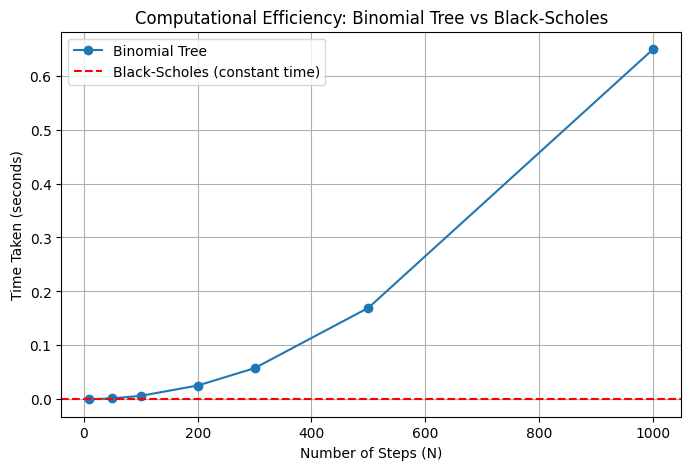

Black-Scholes computation time: 0.000971 seconds


In [17]:
# --- Parameters for testing ---
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
Ns = [10, 50, 100, 200, 300, 500, 1000]
times_binomial = []

# --- Time Binomial Tree for increasing N ---
for N in Ns:
    start = time.time()
    binomial_tree_price(S, K, T, r, sigma, N)
    end = time.time()
    times_binomial.append(end - start)

# --- Time Black-Scholes once ---
start = time.time()
black_scholes_with_greeks(S, K, T, r, sigma)['price']
bs_time = time.time() - start

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(Ns, times_binomial, label='Binomial Tree', marker='o')
plt.axhline(bs_time, color='red', linestyle='--', label='Black-Scholes (constant time)')
plt.xlabel("Number of Steps (N)")
plt.ylabel("Time Taken (seconds)")
plt.title("Computational Efficiency: Binomial Tree vs Black-Scholes")
plt.legend()
plt.grid(True)
plt.show()

print(f"Black-Scholes computation time: {bs_time:.6f} seconds")


**Conclusion**:
The Black-Scholes model is computationally faster due to its closed-form formula.
In contrast, the Binomial Tree model’s time increases with the number of steps N, making it less efficient at high resolution.

### 2. Convergence of Binomial Tree to Black-Scholes Price


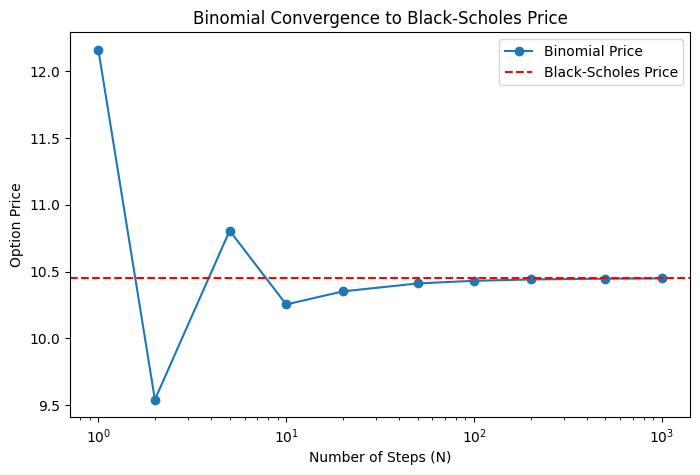

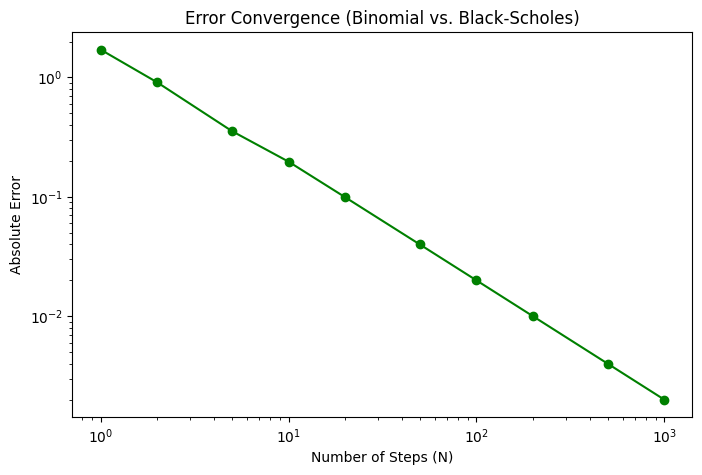

In [18]:
S0, K, T, r, sigma = 100, 100, 1, 0.05, 0.2

# Get Black-Scholes price (call only)
bs_price = black_scholes_with_greeks(S0, K, T, r, sigma, option_type='call')['price']

Ns = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
binomial_prices = []
errors = []

for N in Ns:
    price = binomial_tree_price(S0, K, T, r, sigma, N, option_type='call')
    binomial_prices.append(price)
    errors.append(abs(price - bs_price))

# Price convergence plot
plt.figure(figsize=(8,5))
plt.plot(Ns, binomial_prices, 'o-', label='Binomial Price')
plt.axhline(bs_price, color='red', linestyle='--', label='Black-Scholes Price')
plt.xscale('log')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Option Price')
plt.title('Binomial Convergence to Black-Scholes Price')
plt.legend()
plt.show()

# Error convergence plot
plt.figure(figsize=(8,5))
plt.plot(Ns, errors, 'o-', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Absolute Error')
plt.title('Error Convergence (Binomial vs. Black-Scholes)')
plt.show()

**Conclusion**: As the number of steps in the binomial tree increases, the option price computed by the binomial model approaches the analytical price given by the Black-Scholes formula. For small N, the binomial model provides a rough approximation. As N becomes large, the approximation improves rapidly and matches the Black-Scholes price very closely.

Above, we show the option price computed by the binomial model for increasing values of N, alongside the Black-Scholes price. We also plot the absolute error as N increases to illustrate the convergence.

### 3. Model sensitivity to various parameters

##### a. Sensitivity to Volatility (σ)

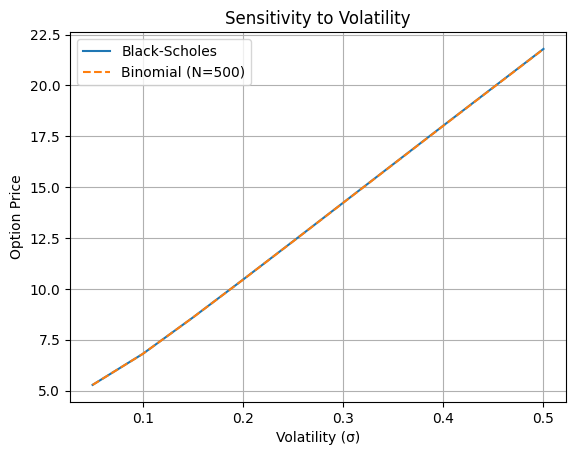

In [19]:
vols = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
bs_prices = []
binomial_prices = []

for sigma in vols:
    bs_price = black_scholes_with_greeks(100, 100, 1, 0.05, sigma)['price']
    bin_price = binomial_tree_price(100, 100, 1, 0.05, sigma, 500)
    bs_prices.append(bs_price)
    binomial_prices.append(bin_price)

plt.plot(vols, bs_prices, label='Black-Scholes')
plt.plot(vols, binomial_prices, label='Binomial (N=500)', linestyle='--')
plt.xlabel('Volatility (σ)')
plt.ylabel('Option Price')
plt.title('Sensitivity to Volatility')
plt.legend()
plt.grid(True)
plt.show()


**Conclusion:** Option prices generally increase with volatility, as higher volatility increases the chance of the option expiring in the money. Both Black-Scholes and Binomial models should reflect this trend.

##### b. Sensitivity to time to maturity (T)

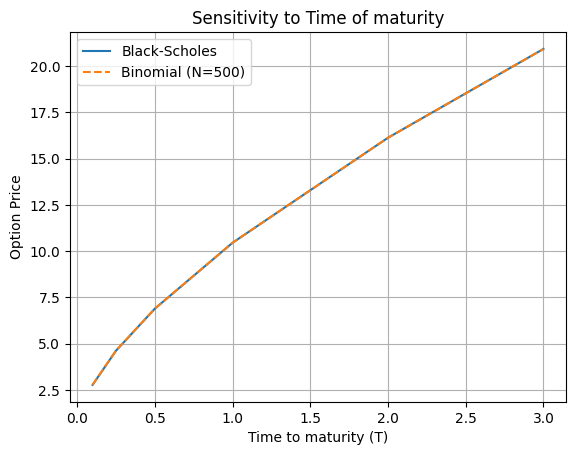

In [20]:
times = [0.1, 0.25, 0.5, 1, 2, 3]
bs_prices = []
binomial_prices = []

for t in times:
    bs_price = black_scholes_with_greeks(100, 100, t, 0.05, 0.2)['price']
    bin_price = binomial_tree_price(100, 100, t, 0.05, 0.2, 500)
    bs_prices.append(bs_price)
    binomial_prices.append(bin_price)

plt.plot(times, bs_prices, label='Black-Scholes')
plt.plot(times, binomial_prices, label='Binomial (N=500)', linestyle='--')
plt.xlabel('Time to maturity (T)')
plt.ylabel('Option Price')
plt.title('Sensitivity to Time of maturity')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion**:
Option prices increase with longer time to maturity for both call and put options.  
This is because more time provides more opportunity for the underlying asset to move favorably.

- **Black-Scholes** and **Binomial Tree** models both capture this effect well.
- The price increase is more significant for options that are **at-the-money**, where uncertainty plays a bigger role.
- As time to expiry approaches zero, the option price quickly converges to its **intrinsic value**.

Overall, both models are consistent in how they respond to changes in time to maturity, especially for European options.


##### c. Sensitivity to risk-free interest rate (r)

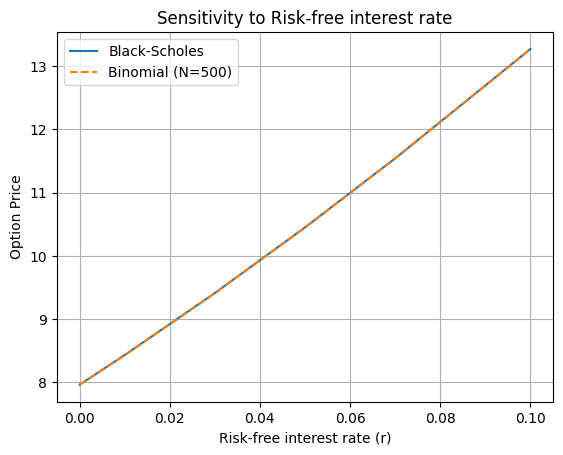

In [21]:
rates = [0.0, 0.01, 0.03, 0.05, 0.07, 0.1]

bs_prices = []
binomial_prices = []

for r in rates:
    bs_price = black_scholes_with_greeks(100, 100, 1, r, 0.2)['price']
    bin_price = binomial_tree_price(100, 100, 1, r, 0.2, 500)
    bs_prices.append(bs_price)
    binomial_prices.append(bin_price)

plt.plot(rates, bs_prices, label='Black-Scholes')
plt.plot(rates, binomial_prices, label='Binomial (N=500)', linestyle='--')
plt.xlabel('Risk-free interest rate (r)')
plt.ylabel('Option Price')
plt.title('Sensitivity to Risk-free interest rate')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion**:
As the risk-free interest rate increases, the value of European **call options** also increases.  
This is because a higher interest rate reduces the present value of the strike price, making the option more valuable today.

- Both **Black-Scholes** and **Binomial Tree** models show a nearly identical linear relationship between price and interest rate.
- The impact is more noticeable for options with longer time to maturity.

This confirms that both models correctly incorporate the time-value-of-money through discounting.

##### d. Sensitivity to strike price (K)

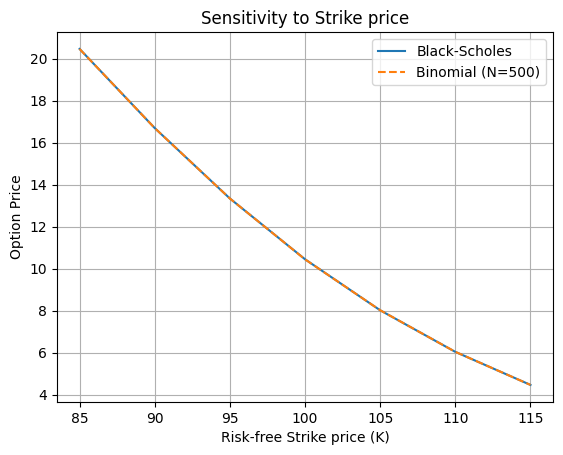

In [22]:
strike_prices = [85,90,95,100,105,110,115]

bs_prices = []
binomial_prices = []

for K in strike_prices:
    bs_price = black_scholes_with_greeks(100, K, 1, 0.05, 0.2)['price']
    bin_price = binomial_tree_price(100, K, 1, 0.05, 0.2, 500)
    bs_prices.append(bs_price)
    binomial_prices.append(bin_price)

plt.plot(strike_prices, bs_prices, label='Black-Scholes')
plt.plot(strike_prices, binomial_prices, label='Binomial (N=500)', linestyle='--')
plt.xlabel('Risk-free Strike price (K)')
plt.ylabel('Option Price')
plt.title('Sensitivity to Strike price')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion**:
Option prices decrease as the **strike price increases**, which makes sense — a higher strike makes the call option less likely to finish in-the-money.

- Both **Black-Scholes** and **Binomial Tree** models show a smooth, decreasing curve.
- The decline is nonlinear, and more pronounced when the strike is near the current stock price (ATM region).

This confirms that both models react consistently to changing strike values, with excellent agreement across the tested range.


### 4. Comparison with real market data **(AAPL)**

In [23]:
# 1. Fetch risk-free rate from 1-year Treasury yield (~4.13% as of Jun 9, 2025)
ticker_rf = yf.Ticker("^IRX")  # 13-week T-bill proxy; adjust if needed
r = ticker_rf.info.get('lastPrice', 4.13) / 100  # convert to decimal
print(f"Using risk-free rate r = {r:.4f}")

# 2. Choose underlying and expiry
under = yf.Ticker("AAPL")
expiry = under.options[1]  # pick nearest expiry; you can specify manually

Using risk-free rate r = 0.0413


,type,K,Market,IV,T,BS,Binomial
0,call,110.0,90.89,1.658205,0.034587,87.122652,87.121141
1,call,120.0,82.10,1.126957,0.034587,76.719852,76.719176
2,call,130.0,73.60,1.036138,0.034587,66.808096,66.807557
3,call,135.0,64.72,0.710940,0.034587,61.656594,61.656386
4,call,140.0,63.51,0.884767,0.034587,56.842187,56.840892
...,...,...,...,...,...,...,...
24,put,235.0,30.25,0.636234,0.034587,38.954396,38.951653
25,put,240.0,35.35,0.682132,0.034587,43.897465,43.897367
26,put,245.0,33.50,0.743655,0.034587,48.926355,48.924397
27,put,250.0,48.20,0.784670,0.034587,53.871526,53.870780


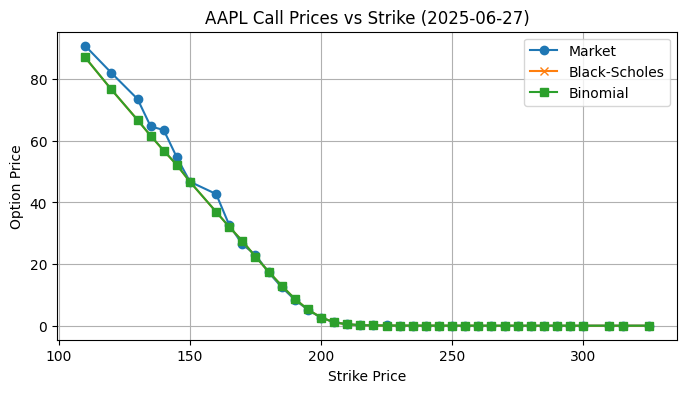

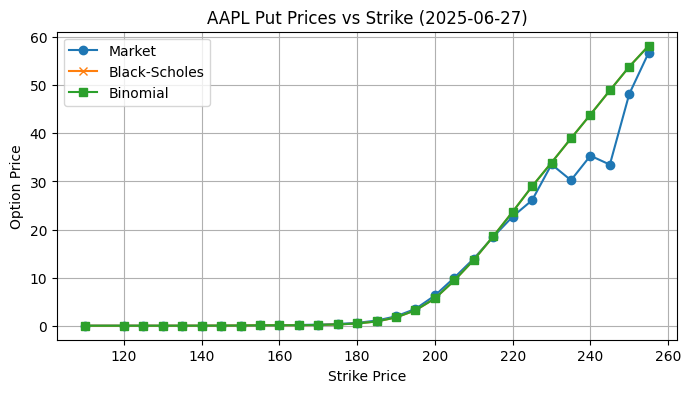

In [24]:
# 3. Get option chain
opt = under.option_chain(expiry)
calls = opt.calls.dropna(subset=['impliedVolatility'])
puts = opt.puts.dropna(subset=['impliedVolatility'])

# 4. Get underlying price and time to expiry
S0 = under.history(period='1d')['Close'].iloc[-1]
expiry_dt = datetime.strptime(expiry, "%Y-%m-%d")
T = (expiry_dt - datetime.now()).total_seconds() / (365 * 24 * 60 * 60)

def compare_group(df, option_type='call'):
    res = []
    for _, r0 in df.iterrows():
        K = r0['strike']
        Mkt = r0['lastPrice']
        sigma = r0['impliedVolatility']
        if sigma <= 0 or pd.isna(Mkt):
            continue
        try:
            bs_out = black_scholes_with_greeks(S0, K, T, r, sigma, option_type)
            bs = bs_out['price']
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)
                bt = binomial_tree_price(S0, K, T, r, sigma, N=300, option_type=option_type)
            if not np.isfinite(bs) or not np.isfinite(bt):
                continue
            res.append([
                option_type, K, Mkt, sigma, T, bs, bt
            ])
        except:
            continue
    return pd.DataFrame(res, columns=['type','K','Market','IV','T','BS','Binomial'])



# 6. Build comparisons for both call and put
df_cmp = pd.concat([compare_group(calls, 'call'), compare_group(puts, 'put')])

# 7. Display the table
display(df_cmp.sort_values(['type','K']))

# 8. Plot results
for optype, grp in df_cmp.groupby('type'):
    plt.figure(figsize=(8,4))
    plt.plot(grp['K'], grp['Market'], label='Market', marker='o')
    plt.plot(grp['K'], grp['BS'], label='Black-Scholes', marker='x')
    plt.plot(grp['K'], grp['Binomial'], label='Binomial', marker='s')
    plt.title(f"{under.ticker} {optype.capitalize()} Prices vs Strike ({expiry})")
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.legend()
    plt.grid(True)
    plt.show()

**There are observed outliers in the market where the models do not perform very well. These outliers will be discussed below.**

- Observed notable outliers in model accuracy.
12 outliers found out of 68 total options.


,type,K,Market,IV,T,BS,Binomial,BS_Error,Binomial_Error
26,put,245.0,33.50,0.743655,0.034587,48.926355,48.924397,15.426355,15.424397
24,put,235.0,30.25,0.636234,0.034587,38.954396,38.951653,8.704396,8.701653
25,put,240.0,35.35,0.682132,0.034587,43.897465,43.897367,8.547465,8.547367
2,call,130.0,73.60,1.036138,0.034587,66.808096,66.807557,6.791904,6.792443
4,call,140.0,63.51,0.884767,0.034587,56.842187,56.840892,6.667813,6.669108
7,call,160.0,42.75,0.611332,0.034587,36.953001,36.952769,5.796999,5.797231
27,put,250.0,48.20,0.784670,0.034587,53.871526,53.870780,5.671526,5.670780
1,call,120.0,82.10,1.126957,0.034587,76.719852,76.719176,5.380148,5.380824
0,call,110.0,90.89,1.658205,0.034587,87.122652,87.121141,3.767348,3.768859
3,call,135.0,64.72,0.710940,0.034587,61.656594,61.656386,3.063406,3.063614


_______________________________________
- Acceptable errors (below $2):


,type,K,Market,BS,Binomial,BS_Error,Binomial_Error
6,call,150.0,46.75,46.728610,46.727857,0.021390,0.022143
8,call,165.0,32.65,32.062936,32.062559,0.587064,0.587441
9,call,170.0,26.43,27.491138,27.492024,1.061138,1.062024
10,call,175.0,23.01,22.417497,22.417601,0.592503,0.592399
11,call,180.0,17.30,17.561220,17.558597,0.261220,0.258597
12,call,185.0,12.52,12.975951,12.977103,0.455951,0.457103
13,call,190.0,8.43,8.729529,8.729703,0.299529,0.299703
14,call,195.0,5.18,5.272228,5.272262,0.092228,0.092262
15,call,200.0,2.58,2.647885,2.644717,0.067885,0.064717
16,call,205.0,1.17,1.137449,1.139062,0.032551,0.030938


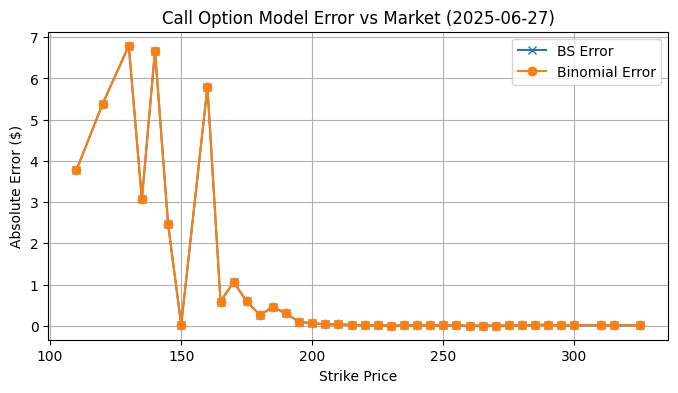

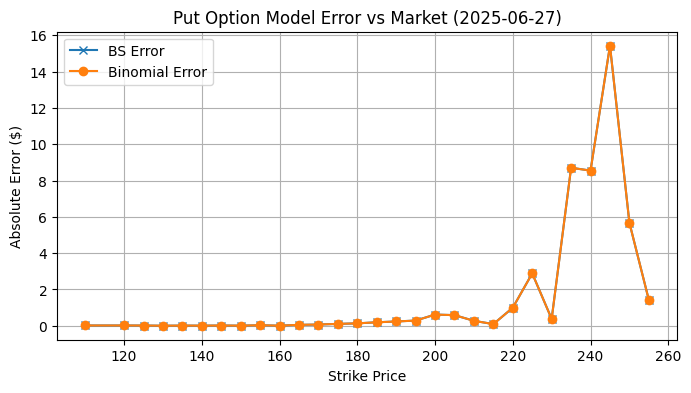

In [25]:
# --- Calculate errors ---
df_cmp['BS_Error'] = abs(df_cmp['Market'] - df_cmp['BS'])
df_cmp['Binomial_Error'] = abs(df_cmp['Market'] - df_cmp['Binomial'])

# --- Identify outliers ---
outliers = df_cmp[(df_cmp['BS_Error'] > 2) | (df_cmp['Binomial_Error'] > 2)]

if not outliers.empty:
    print("- Observed notable outliers in model accuracy.")
    print(f"{len(outliers)} outliers found out of {len(df_cmp)} total options.")
    display(outliers.sort_values(by=['BS_Error', 'Binomial_Error'], ascending=False))
    print("_______________________________________")
    print("- Acceptable errors (below $2):")
else:
    print("- No significant outliers found (errors within acceptable range).")

# --- Table of only acceptable errors (not outliers) ---
df_cmp_no_outliers = df_cmp[(df_cmp['BS_Error'] <= 2) & (df_cmp['Binomial_Error'] <= 2)]
display(df_cmp_no_outliers[['type', 'K', 'Market', 'BS', 'Binomial', 'BS_Error', 'Binomial_Error']])

# --- Plot error vs strike price for each option type (show all) ---
for optype, grp in df_cmp.groupby('type'):
    plt.figure(figsize=(8,4))
    plt.plot(grp['K'], grp['BS_Error'], label='BS Error', marker='x')
    plt.plot(grp['K'], grp['Binomial_Error'], label='Binomial Error', marker='o')
    plt.title(f"{optype.capitalize()} Option Model Error vs Market ({expiry})")
    plt.xlabel("Strike Price")
    plt.ylabel("Absolute Error ($)")
    plt.grid(True)
    plt.legend()
    plt.show()


#### **Outlier Observations**

During the model vs. market comparison, some options consistently exhibited unusually large errors between theoretical model prices and real market prices.  
**These outliers may occur at different strikes, maturities, or volatilities depending on the data and date of analysis.**

Common characteristics and causes of outliers include:

- **Very high or very low implied volatility (IV):**  
  - Extremely high IV can cause models to overprice deep ITM or OTM options.
  - Extremely low IV can lead to severe underpricing.
- **Short time to maturity:**  
  - With just a few days or hours to expiry, prices become highly sensitive to microstructure (liquidity, bid-ask spreads), not captured by either model.
- **Deep ITM/OTM or illiquid strikes:**  
  - Market prices at far-from-the-money strikes can deviate from theory due to low trading volume, wide spreads, or stale quotes.

> **In summary:**  
> Outliers are a natural consequence of using simplified mathematical models on complex, real-world financial data.  
> Both Black-Scholes and Binomial models are reliable for most at-the-money and moderately OTM/ITM options with reasonable IV and T, but can fail at the extremes due to practical effects not modeled here.

These conclusions are illustrated in the attached plots:
- AAPL Call/Put Price vs Strike
- Model Error vs Strike (Call & Put)

#### Why are model errors largest for low-strike calls and high-strike puts, especially close to expiry?

These options are far from the money (deep ITM for calls, deep OTM for puts). In the final weeks before expiry, theoretical models predict their prices will rapidly collapse to intrinsic value (or zero). However, real-world market effects—like wide bid-ask spreads, stale prices, and low liquidity—cause observed market prices to deviate significantly from model predictions.

Thus, large errors at extreme strikes with short time to expiry are a reflection of practical market realities, not a failure of the theoretical models.


###### .
---

## **Conclusion: When is One Model Preferable Over the Other?**

Both the **Black-Scholes** and **Binomial Tree** models are effective in pricing European options, but their performance varies depending on market conditions:

##### **Black-Scholes is preferable when**:
- Volatility is stable and not extremely high or low
- Time to maturity is reasonable (not near expiry)
- You need fast, closed-form pricing

##### **Binomial Tree is preferable when**:
- You want to model step-wise price movements or discrete hedging
- You're dealing with options close to expiry (very short T)
- You want flexibility to extend into American option pricing (beyond this project)

##### **Observations from our comparison**:
- For well-behaved, liquid options near-the-money, **both models produce near-identical results**.
- Large errors occur in both models when **implied volatility is unrealistic** (too high or too low), or **time to expiry is extremely short**.
- Binomial Tree, while slower, offers greater **control over accuracy via N** and matches Black-Scholes closely at high N.

> *In practice: **Black-Scholes is faster and sufficient for most European option pricing**, while **Binomial Tree is a more flexible tool** when stepping beyond idealized assumptions.*
